In [3]:
import collections
import igraph
import matplotlib.pyplot as plt
import networkx as nx
import netbone as nb
import numpy as np
import pandas as pd
import pickle

import os

## Loading the nets

In [4]:
# Reading data
original_path = '../../../data/02_network_data'
backbones_path = '../../../data/03_backbone_nets'

### Utils

In [5]:
# remove self-loops
def simplify_and_return(data: pd.DataFrame, directed=False, weighted=True, strategy="sum"):
    # Creating the corresponding igraph object
    print("Creating the igraph object from data...")
    g = igraph.Graph.TupleList(
                data[['source', 'target', 'weight']].itertuples(index=False),
                directed=False,
                weights=True)
    print("-"*50)

    # Some info on the graph
    print(f"g has {g.vcount()} nodes and {g.ecount()} edges")
    print(f"g is simple: {g.is_simple()}")
    print(f"g is weighted: {g.is_weighted()}")
    print("-"*50)

    # Simplifying the graph
    print("Simplifying g...")
    g = g.simplify(combine_edges=dict(weight=strategy))

    # Counting isolated
    degrees = g.degree()
    vertices_with_degree_zero = [v for v, d in enumerate(degrees) if d == 0]

    # Some info on the graph
    print(f"g has {g.vcount()} nodes and {g.ecount()} edges")
    print(f"g has {len(vertices_with_degree_zero)} isolated nodes")
    print(f"g is simple: {g.is_simple()}")
    print(f"g is weighted: {g.is_weighted()}")
    print("-"*50)

    # Returning to df
    print("Re-creating data (from simple graph)...")
    edgelist = [(g.vs[e.source]["name"], g.vs[e.target]["name"], g.es[idx]["weight"]) for idx, e in enumerate(g.es)]
    print(edgelist[:3])
    data_simple = pd.DataFrame(edgelist, columns=['source', 'target', 'weight'])
    data_simple['source'] = data_simple['source'].astype(str)
    data_simple['target'] = data_simple['target'].astype(str)
    data_simple['weight'] = data_simple['weight'].astype(int)
    print(data_simple.head())
    print("-"*50)
    
    return data_simple

### Original nets

In [6]:
before_data = pd.read_csv(os.path.join(original_path, 'before_campaign.graph'))
during_data = pd.read_csv(os.path.join(original_path, 'electoral_campaign.graph'))
after_data = pd.read_csv(os.path.join(original_path, 'after_elections.graph'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape) 

Before data has shape:  (1013501, 3)
During data has shape:  (1373674, 3)
After data has shape:  (1330480, 3)


In [7]:
# Simplifying original nets
before_data = simplify_and_return(before_data)
during_data = simplify_and_return(during_data)
after_data = simplify_and_return(after_data)

Creating the igraph object from data...
--------------------------------------------------
g has 120644 nodes and 1013501 edges
g is simple: False
g is weighted: True
--------------------------------------------------
Simplifying g...
g has 120644 nodes and 1009968 edges
g has 30 isolated nodes
g is simple: True
g is weighted: True
--------------------------------------------------
Re-creating data (from simple graph)...
[('1111697667946659840', '52424550', 355.0), ('1111697667946659840', '289400495', 125.0), ('1111697667946659840', '2983707267', 114.0)]
                source              target  weight
0  1111697667946659840            52424550     355
1  1111697667946659840           289400495     125
2  1111697667946659840          2983707267     114
3  1111697667946659840           274093178      64
4  1111697667946659840  999578121123848192      35
--------------------------------------------------
Creating the igraph object from data...
------------------------------------------

In [8]:
# Creating directed graphs
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

# Creating indirected graphs
before_graph_ind = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
during_graph_ind = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
after_graph_ind = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

# Some basic stats
print("Before graph (indirected) has: ", before_graph_ind.number_of_nodes(), " nodes and ", before_graph_ind.number_of_edges(), " edges")
print("During graph (indirected) has: ", during_graph_ind.number_of_nodes(), " nodes and ", during_graph_ind.number_of_edges(), " edges")
print("After graph (indirected) has: ", after_graph_ind.number_of_nodes(), " nodes and ", after_graph_ind.number_of_edges(), " edges")

Before graph has:  120614  nodes and  1009968  edges
During graph has:  183688  nodes and  1366268  edges
After graph has:  253854  nodes and  1325370  edges
Before graph (indirected) has:  120614  nodes and  1009968  edges
During graph (indirected) has:  183688  nodes and  1366268  edges
After graph (indirected) has:  253854  nodes and  1325370  edges


### Backbone networks

In [9]:
before_data_backbone = pd.read_csv(os.path.join(backbones_path, 'before_campaign_backbone.csv'))
during_data_backbone = pd.read_csv(os.path.join(backbones_path, 'electoral_campaign_backbone.csv'))
after_data_backbone = pd.read_csv(os.path.join(backbones_path, 'after_elections_backbone.csv'))

# Forcing the conversion to string 
before_data_backbone['source'] = before_data_backbone['source'].astype(str)
before_data_backbone['target'] = before_data_backbone['target'].astype(str)
during_data_backbone['source'] = during_data_backbone['source'].astype(str)
during_data_backbone['target'] = during_data_backbone['target'].astype(str)
after_data_backbone['source'] = after_data_backbone['source'].astype(str)
after_data_backbone['target'] = after_data_backbone['target'].astype(str)

# Shapes
print("(backbone) Before data has shape: ", before_data.shape)
print("(backbone) During data has shape: ", during_data.shape)
print("(backbone) After data has shape: ", after_data.shape)

(backbone) Before data has shape:  (1009968, 3)
(backbone) During data has shape:  (1366268, 3)
(backbone) After data has shape:  (1325370, 3)


In [10]:
# Creating directed graphs
before_graph_backbone = nx.from_pandas_edgelist(before_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
during_graph_backbone = nx.from_pandas_edgelist(during_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
after_graph_backbone = nx.from_pandas_edgelist(after_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("(backbone) Before graph has: ", before_graph_backbone.number_of_nodes(), " nodes and ", before_graph_backbone.number_of_edges(), " edges")
print("(backbone) During graph has: ", during_graph_backbone.number_of_nodes(), " nodes and ", during_graph_backbone.number_of_edges(), " edges")
print("(backbone) After graph has: ", after_graph_backbone.number_of_nodes(), " nodes and ", after_graph_backbone.number_of_edges(), " edges")

# Creating indirected graphs
before_graph_ind_backbone = nx.from_pandas_edgelist(before_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
during_graph_ind_backbone = nx.from_pandas_edgelist(during_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.Graph())
after_graph_ind_backbone = nx.from_pandas_edgelist(after_data_backbone, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

# Some basic stats
print("(backbone) Before graph (indirected) has: ", before_graph_ind_backbone.number_of_nodes(), " nodes and ", before_graph_ind_backbone.number_of_edges(), " edges")
print("(backbone) During graph (indirected) has: ", during_graph_ind_backbone.number_of_nodes(), " nodes and ", during_graph_ind_backbone.number_of_edges(), " edges")
print("(backbone) After graph (indirected) has: ", after_graph_ind_backbone.number_of_nodes(), " nodes and ", after_graph_ind_backbone.number_of_edges(), " edges")

(backbone) Before graph has:  12008  nodes and  38209  edges
(backbone) During graph has:  18150  nodes and  56953  edges
(backbone) After graph has:  15943  nodes and  42864  edges
(backbone) Before graph (indirected) has:  12008  nodes and  38209  edges
(backbone) During graph (indirected) has:  18150  nodes and  56953  edges
(backbone) After graph (indirected) has:  15943  nodes and  42864  edges


## Evaluating network properties

In [32]:
def eval_properties(graph, graph_ind):
    # Reciprocity
    print("Reciprocity: ", nx.reciprocity(graph))

    # Density
    print("Density: ", nx.density(graph))

    # Average degree
    print("Average degree (ind): ", np.mean(list(dict(graph_ind.degree()).values())))

    # Average in-degree
    print("Average in-degree: ", np.mean(list(dict(graph.in_degree()).values())))

    # % of nodes with 0 in-degree (sources)
    print("% of sources (0 in-degree): ", len([n for n, d in graph.in_degree() if d == 0])/graph.number_of_nodes())

    # % of nodes with 0 out-degree (sinks)
    print("% of sinks (0 out-degree): ", len([n for n, d in graph.out_degree() if d == 0])/graph.number_of_nodes())

    # Degree assortativity
    print("Degree assortativity (ind): ", nx.degree_assortativity_coefficient(graph_ind))

    # Degree assortativity
    print("Degree assortativity: ", nx.degree_assortativity_coefficient(graph))

    # Transitivity
    print("Transitivity: ", nx.transitivity(graph_ind))

    # Clustering coefficient
    print("Clustering coefficient: ", nx.average_clustering(graph_ind))

    # Number of strong connected components
    print("Number of strong connected components: ", nx.number_strongly_connected_components(graph))

    # Number of weak connected components
    print("Number of weak connected components: ", nx.number_weakly_connected_components(graph))

    # Connected components
    cc = list(nx.connected_components(graph_ind))

    if len(cc) > 1:
        # get the largest component
        cc_max = graph.subgraph(cc[0])
        print("Number of nodes in the largest component: ", cc_max.number_of_nodes())

        try:
            # Average shortest path
            print("Average shortest path in the largest component: ", nx.average_shortest_path_length(cc_max))
        except nx.NetworkXError:
            print("Average shortest path in the largest component: ", "Not strongly connected", "Trying on the indirected graph...")
            print("Average shortest path in the largest component: ", nx.average_shortest_path_length(cc_max.to_undirected()))

        try:
            # Diameter
            print("Diameter of the largest cc: ", nx.diameter(cc_max))
        except nx.NetworkXError:
            print("Diameter of the largest cc: ", "Not strongly connected", "Trying on the indirected graph...")
            print("Diameter of the largest cc: ", nx.diameter(cc_max.to_undirected()))
    else:
        try:
            # Average shortest path
            print("Average shortest path: ", nx.average_shortest_path_length(graph))
        except nx.NetworkXError:
            print("Average shortest path: ", "Not possible to compute", "Trying on the indirected graph...")
            print("Average shortest path: ", nx.average_shortest_path_length(graph_ind))

        try:
             # Diameter
            print("Diameter: ", nx.diameter(graph))
        except nx.NetworkXError:
            print("Diameter: ", "Not possible to compute", "Trying on the indirected graph...")
            print("Diameter: ", nx.diameter(graph_ind))

In [36]:
def eval_properties_short(graph, graph_ind):
    # Reciprocity
    print("Reciprocity: ", nx.reciprocity(graph))

    # Density
    print("Density: ", nx.density(graph))

    # Average degree
    print("Average degree (ind): ", np.mean(list(dict(graph_ind.degree()).values())))

    # Average in-degree
    print("Average in-degree: ", np.mean(list(dict(graph.in_degree()).values())))

    # % of nodes with 0 in-degree (sources)
    print("% of sources (0 in-degree): ", len([n for n, d in graph.in_degree() if d == 0])/graph.number_of_nodes())

    # % of nodes with 0 out-degree (sinks)
    print("% of sinks (0 out-degree): ", len([n for n, d in graph.out_degree() if d == 0])/graph.number_of_nodes())

    # Degree assortativity
    print("Degree assortativity (ind): ", nx.degree_assortativity_coefficient(graph_ind))

    # Degree assortativity
    print("Degree assortativity: ", nx.degree_assortativity_coefficient(graph))

    # Transitivity
    print("Transitivity: ", nx.transitivity(graph_ind))

    # Clustering coefficient
    print("Clustering coefficient: ", nx.average_clustering(graph_ind))

    # Number of strong connected components
    print("Number of strong connected components: ", nx.number_strongly_connected_components(graph))

    # Number of weak connected components
    print("Number of weak connected components: ", nx.number_weakly_connected_components(graph))

    # Connected components
    cc = list(nx.connected_components(graph_ind))
    cc_max = graph.subgraph(cc[0])
    print("Number of nodes/edges in the largest component: ", cc_max.number_of_nodes(), "/", cc_max.number_of_edges())

### Before propaganda

In [37]:
# original network
eval_properties_short(before_graph, before_graph_ind)

Reciprocity:  0.0
Density:  6.942498162445703e-05
Average degree (ind):  16.74711061734127
Average in-degree:  8.373555308670635
% of sources (0 in-degree):  0.0023794916013066478
% of sinks (0 out-degree):  0.9051188087618353
Degree assortativity (ind):  -0.26111811704200866
Degree assortativity:  -0.19312691537163343
Transitivity:  0.020323290658872065
Clustering coefficient:  0.07030188639607528
Number of strong connected components:  120614
Number of weak connected components:  200
Number of nodes/edges in the largest component:  118782  /  1008322


In [35]:
eval_properties(before_graph_backbone, before_graph_ind_backbone)

Reciprocity:  0.0
Density:  0.00026500891357678487
Average degree (ind):  6.363924050632911
Average in-degree:  3.1819620253164556
% of sources (0 in-degree):  0.0073284477015323115
% of sinks (0 out-degree):  0.7902231845436376
Degree assortativity (ind):  -0.3528463372863449
Degree assortativity:  -0.3570842565412934
Transitivity:  0.0054079583131175545
Clustering coefficient:  0.03339881119919926
Number of strong connected components:  12008
Number of weak connected components:  39
Number of nodes in the largest component:  11874
Average shortest path in the largest component:  0.11209434512562995
Diameter of the largest cc:  Not strongly connected Trying on the indirected graph...
Diameter of the largest cc:  11


### Electoral campaign

In [38]:
# original network
eval_properties_short(during_graph, during_graph_ind)

Reciprocity:  0.0
Density:  4.04926957009368e-05
Average degree (ind):  14.875963590435957
Average in-degree:  7.437981795217978
% of sources (0 in-degree):  0.011563085231479465
% of sinks (0 out-degree):  0.8219480858847611
Degree assortativity (ind):  -0.1800762067863841
Degree assortativity:  -0.17426710676399415
Transitivity:  0.024833955528452276
Clustering coefficient:  0.06626492069842835
Number of strong connected components:  183688
Number of weak connected components:  1730
Number of nodes/edges in the largest component:  178665  /  1362937


In [33]:
eval_properties(during_graph_backbone, during_graph_ind_backbone)

Reciprocity:  0.0
Density:  0.00017289692743887566
Average degree (ind):  6.275812672176309
Average in-degree:  3.1379063360881543
% of sources (0 in-degree):  0.028705234159779613
% of sinks (0 out-degree):  0.7503030303030302
Degree assortativity (ind):  -0.23274757650292868
Degree assortativity:  -0.25497647031714304
Transitivity:  0.006494839274780131
Clustering coefficient:  0.04669296659182464
Number of strong connected components:  18150
Number of weak connected components:  377
Number of nodes in the largest component:  17155
Average shortest path in the largest component:  0.13027033691095055
Diameter of the largest cc:  Not strongly connected Trying on the indirected graph...
Diameter of the largest cc:  13


### After elections

In [39]:
# original network
eval_properties_short(after_graph, after_graph_ind)

Reciprocity:  0.0
Density:  2.0566994163165453e-05
Average degree (ind):  10.44198633860408
Average in-degree:  5.22099316930204
% of sources (0 in-degree):  0.012184168852962727
% of sinks (0 out-degree):  0.8490352722431004
Degree assortativity (ind):  -0.05466021917244073
Degree assortativity:  -0.14468829869737096
Transitivity:  0.0056590672076504075
Clustering coefficient:  0.04107953808380127
Number of strong connected components:  253854
Number of weak connected components:  2507
Number of nodes/edges in the largest component:  247098  /  1321096


In [34]:
eval_properties(after_graph_backbone, after_graph_ind_backbone)

Reciprocity:  0.0
Density:  0.0001686474758083293
Average degree (ind):  5.377156118672771
Average in-degree:  2.6885780593363857
% of sources (0 in-degree):  0.033055259361475256
% of sinks (0 out-degree):  0.7597691776955403
Degree assortativity (ind):  -0.19463161475327298
Degree assortativity:  -0.244163037349016
Transitivity:  0.004137125192766811
Clustering coefficient:  0.02481852360569492
Number of strong connected components:  15943
Number of weak connected components:  382
Number of nodes in the largest component:  14961
Average shortest path in the largest component:  0.08616471453229377
Diameter of the largest cc:  Not strongly connected Trying on the indirected graph...
Diameter of the largest cc:  15


## Plotting degree distribution

In [19]:
output_path = '../../../data/03_backbone_nets/latex_data'

In [11]:
def eval_ccdf(graph):
    degree_sequence = sorted([d for _, d in graph.in_degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    cs = np.cumsum(cnt)
    return deg, cs

### Before electoral campaign

In [12]:
deg_before, cs_before = eval_ccdf(before_graph)
deg_before_backbone, cs_before_backbone = eval_ccdf(before_graph_backbone)

In [20]:
# store the ccdf in plain text
np.savetxt(os.path.join(output_path, 'ccdf_before.txt'), np.array([deg_before, cs_before]).T, fmt='%d')
np.savetxt(os.path.join(output_path, 'ccdf_before_backbone.txt'), np.array([deg_before_backbone, cs_before_backbone]).T, fmt='%d')

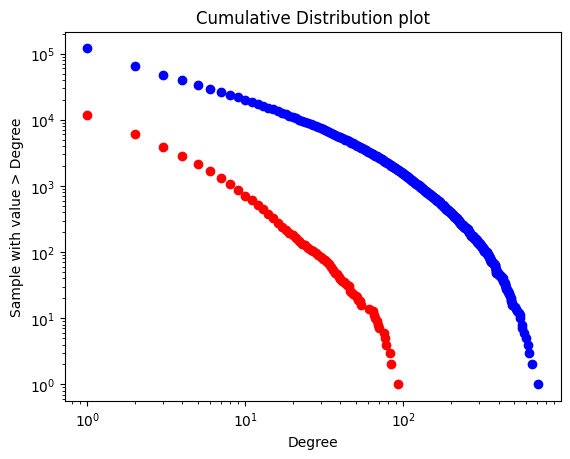

In [13]:
plt.loglog(deg_before, cs_before, 'bo')
plt.loglog(deg_before_backbone, cs_before_backbone, 'ro')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

### During electoral campaign

In [14]:
deg_during, cs_during = eval_ccdf(during_graph)
deg_during_backbone, cs_during_backbone = eval_ccdf(during_graph_backbone)

In [21]:
# store the ccdf in plain text
np.savetxt(os.path.join(output_path, 'ccdf_during.txt'), np.array([deg_during, cs_during]).T, fmt='%d')
np.savetxt(os.path.join(output_path, 'ccdf_during_backbone.txt'), np.array([deg_during_backbone, cs_during_backbone]).T, fmt='%d')

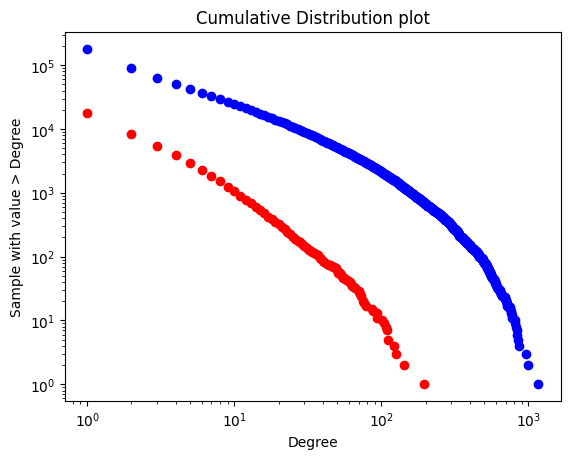

In [15]:
plt.loglog(deg_during, cs_during, 'bo')
plt.loglog(deg_during_backbone, cs_during_backbone, 'ro')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

### After elections

In [16]:
deg_after, cs_after = eval_ccdf(after_graph)
deg_after_backbone, cs_after_backbone = eval_ccdf(after_graph_backbone)

In [22]:
# store the ccdf in plain text
np.savetxt(os.path.join(output_path, 'ccdf_after.txt'), np.array([deg_after, cs_after]).T, fmt='%d')
np.savetxt(os.path.join(output_path, 'ccdf_after_backbone.txt'), np.array([deg_after_backbone, cs_after_backbone]).T, fmt='%d')

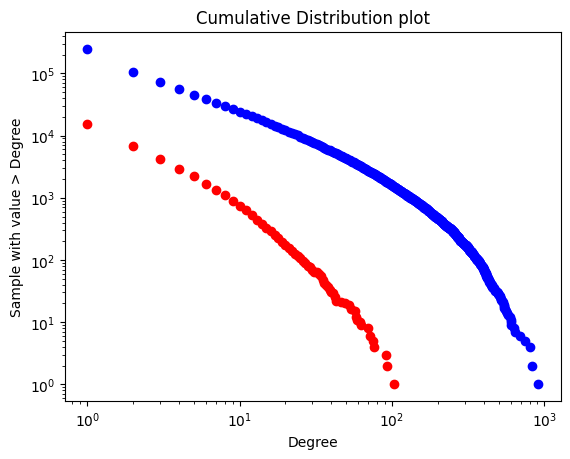

In [17]:
plt.loglog(deg_after, cs_after, 'bo')
plt.loglog(deg_after_backbone, cs_after_backbone, 'ro')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()